# R script to analyse inbreeding in the GLUE dataset 

## Setup

### Libraries required

In [1]:
library(matrixStats)
library(MASS)
library(tidyverse)
library(emmeans)
library(gridExtra)
library(fs)
library(ggridges)
library(data.table)
library(RcppCNPy)
library(R.utils)
library(car)
library(ggrepel)
library(patchwork)
library(Cairo)
library(dplyr)
library(ggpubr)
library(IRdisplay)
library(lme4)
library(lmerTest)
library(MuMIn)
library(glmmTMB)
library(multcomp)
library(DHARMa)

── Attaching packages ──────────────────────────────────────────────────────────── tidyverse 1.3.1 ──

✔ ggplot2 3.4.0      ✔ purrr   0.3.4 
✔ tibble  3.1.7      ✔ dplyr   1.0.10
✔ tidyr   1.2.0      ✔ stringr 1.4.0 
✔ readr   2.1.2      ✔ forcats 0.5.1 

── Conflicts ─────────────────────────────────────────────────────────────── tidyverse_conflicts() ──
✖ dplyr::count()  masks matrixStats::count()
✖ dplyr::filter() masks stats::filter()
✖ dplyr::lag()    masks stats::lag()
✖ dplyr::select() masks MASS::select()


Attachement du package : ‘gridExtra’


L'objet suivant est masqué depuis ‘package:dplyr’:

    combine



Attachement du package : ‘data.table’


Les objets suivants sont masqués depuis ‘package:dplyr’:

    between, first, last


L'objet suivant est masqué depuis ‘package:purrr’:

    transpose


Le chargement a nécessité le package : R.oo

Le chargement a nécessité le package : R.methodsS3

R.methodsS3 v1.8.2 (2022-06-13 22:00:14 UTC) successfully loaded. See ?R.methodsS3 

## Mean values of inbreeding coef per pairs of habitat in each city

In [7]:
list<-c("Albuquerque", "Antwerp", "Armidale","Athens","Buenos_Aires",
        "Calgary","Cape_Town","Christchurch","Kunming","Landshut","Linkoping","Loja","Memphis",
        "Mexico_City","Munich","Palmerston_North","Punta_Arenas","Quito","Sapporo","Tehran",
        "Thessaloniki","Toronto","Vancouver","Warsaw")

samples<-read.csv("/scratch/projects/trifolium/glue/demography/glue_demography/genomic-analyses/resources/glue_noLowCities_sampleSheet_noRelated.txt", header=TRUE, sep="\t")
detail_small<-samples[,(5:6)]
columns<- c("city","habitat_combo","rab","rab_sd","rab_lower","rab_upper","inbred_relatedness","inbred_relatedness_sd","king", "king_sd","king_se") 
table_inbreeding<- data.frame(matrix(nrow = 0, ncol = length(columns))) 


for (city in list){
  data <- read.table(paste0("/scratch/projects/trifolium/glue/demography/glue_demography/results/population_structure/ngsrelate/",city,"/",city,"_4fold_maf0.05_NGSrelate.out"),header=TRUE)
  data$ida<-gsub("_4fold.bam","",as.character(data$ida))
  data$idb<-gsub("_4fold.bam","",as.character(data$idb))
  #name <-paste0(city,'_order_detail')
  tmp <-merge(data, detail_small,  by.x="ida", by.y="sample", all.x=TRUE, all.y=FALSE, sort=FALSE) 
  tmp2 <-merge(tmp, detail_small,  by.x="idb", by.y="sample", all.x=TRUE, all.y=FALSE, sort=FALSE) 
  
  r_r<-subset(tmp2,site.x=="r" & site.y=="r" & rab<=0.5)
  r_u<-subset(tmp2,(site.x=="u" & site.y=="r")|(site.x=="r" & site.y=="u") & rab<=0.5)
  u_u<-subset(tmp2,site.x=="u" & site.y=="u" & rab<=0.5)
  rr_rab<-mean(r_r$rab)
  rr_rab_sd<-sd(r_r$rab)
  rr_rab_se<-sd(r_r$rab)/sqrt(nrow(r_r))
  ru_rab<-mean(r_u$rab)   
  ru_rab_sd<-sd(r_u$rab)
  ru_rab_se<-sd(r_u$rab)/sqrt(nrow(r_u))
  uu_rab<-mean(u_u$rab)
  uu_rab_sd<-sd(u_u$rab)
  uu_rab_se<-sd(u_u$rab)/sqrt(nrow(u_u))
  
  t.score = qt(p=0.025, df=(nrow(r_r)-1),lower.tail=F)
  rr_rab_margin.error <- t.score*rr_rab_se
  rr_rab_lower.bound <- rr_rab - rr_rab_margin.error
  rr_rab_upper.bound <- rr_rab + rr_rab_margin.error
    
  t.score = qt(p=0.025, df=(nrow(r_u)-1),lower.tail=F)
  ru_rab_margin.error <- t.score*ru_rab_se
  ru_rab_lower.bound <- ru_rab - ru_rab_margin.error
  ru_rab_upper.bound <- ru_rab + ru_rab_margin.error
    
  t.score = qt(p=0.025, df=(nrow(u_u)-1),lower.tail=F)
  uu_rab_margin.error <- t.score*uu_rab_se
  uu_rab_lower.bound <- uu_rab - uu_rab_margin.error
  uu_rab_upper.bound <- uu_rab + uu_rab_margin.error
    
  rr_inbred_relatedness<-mean(rbind(r_r$inbred_relatedness_1_2,r_r$inbred_relatedness_2_1))
  rr_inbred_relatedness_sd<-sd(rbind(r_r$inbred_relatedness_1_2,r_r$inbred_relatedness_2_1))
  ru_inbred_relatedness<-mean(rbind(r_u$inbred_relatedness_1_2,r_u$inbred_relatedness_2_1))
  ru_inbred_relatedness_sd<-sd(rbind(r_u$inbred_relatedness_1_2,r_u$inbred_relatedness_2_1))
  uu_inbred_relatedness<-mean(rbind(u_u$inbred_relatedness_1_2,u_u$inbred_relatedness_2_1))
  uu_inbred_relatedness_sd<-sd(rbind(u_u$inbred_relatedness_1_2,u_u$inbred_relatedness_2_1))
  rr_KING<-mean(r_r$KING)
  rr_KING_sd<-sd(r_r$KING)
  rr_KING_se<-sd(r_r$KING)/sqrt(nrow(r_r))
  ru_KING<-mean(r_u$KING)
  ru_KING_sd<-sd(r_u$KING)
  ru_KING_se<-sd(r_u$KING)/sqrt(nrow(r_u))
  uu_KING<-mean(u_u$KING)
  uu_KING_sd<-sd(u_u$KING)
  uu_KING_se<-sd(u_u$KING)/sqrt(nrow(u_u))

    

  table_inbreeding[nrow(table_inbreeding) + 1,] = c(city,"rr",rr_rab,rr_rab_sd,rr_rab_lower.bound,rr_rab_upper.bound,rr_inbred_relatedness,rr_inbred_relatedness_sd,rr_KING,rr_KING_sd,rr_KING_se)
  table_inbreeding[nrow(table_inbreeding) + 1,] = c(city,"ru",ru_rab,ru_rab_sd,ru_rab_lower.bound,ru_rab_upper.bound,ru_inbred_relatedness,ru_inbred_relatedness_sd,ru_KING,ru_KING_sd,ru_KING_se)
  table_inbreeding[nrow(table_inbreeding) + 1,] = c(city,"uu",uu_rab,uu_rab_sd,uu_rab_lower.bound,uu_rab_upper.bound,uu_inbred_relatedness,uu_inbred_relatedness_sd,uu_KING,uu_KING_sd,uu_KING_se)
  
    
    colnames(table_inbreeding)<- c("city","habitat_combo","rab","rab_sd","rab_lower","rab_upper","inbred_relatedness","inbred_relatedness_sd","king", "king_sd","king_se") 
  }

write_delim(table_inbreeding, '../analyses/tables/div_popStruct/relatedness_table.txt', delim = '\t')
bzip2(filename = '../analyses/tables/div_popStruct/relatedness_table.txt', ext = 'bz2', FUN = bzfile, overwrite = TRUE)


In [ ]:
sample_sheet<-read.csv("/scratch/projects/trifolium/glue/demography/glue_demography/genomic-analyses/resources/glue_noLowCities_sampleSheet_noRelated.txt", header=TRUE, sep="\t")
city_detail<-distinct(sample_sheet, city, .keep_all= TRUE)

## merging details per city to the diversity values
inbr_table<-merge(table_inbreeding,city_detail, by.x="city", by.y="city", all.x=TRUE, all.y=FALSE)
inbr_table$city<-sub("Cape_Town", "Cape Town", inbr_table$city)
inbr_table$city<-sub("Buenos_Aires", "Buenos Aires", inbr_table$city)
inbr_table$city<-sub("Mexico_City", "Mexico City", inbr_table$city)
inbr_table$city<-sub("Palmerston_North", "Palmerston N", inbr_table$city)
inbr_table$city<-sub("Punta_Arenas", "Punta Arenas", inbr_table$city)
inbr_table$continent<-sub("EU", "EUROPE", inbr_table$continent)
inbr_table$continent<-sub("ASI", "ASIA", inbr_table$continent)
inbr_table$continent<-sub("AFR", "AFR", inbr_table$continent)
inbr_table$continent<-sub("NAM", "NORTH AM.", inbr_table$continent)
inbr_table$continent<-sub("SAM", "SOUTH AM.", inbr_table$continent)
inbr_table$continent<-sub("OCE", "OCEANIA", inbr_table$continent)
level_order <- c('Antwerp', 'Landshut', 'Linkoping','Munich','Thessaloniki','Warsaw',
                 'Tehran','Kunming','Sapporo','Cape Town',
                 'Albuquerque','Athens','Calgary','Memphis','Mexico City', 'Toronto', 'Vancouver',
                 'Buenos Aires','Loja','Punta Arenas','Quito',
                 'Armidale','Christchurch','Palmerston N') 

inbr_table$continent_order<-factor(inbr_table$continent, levels=c('EUROPE','ASIA','AFR','NORTH AM.','SOUTH AM.','OCEANIA'))
inbr_table$rab<-as.numeric(inbr_table$rab)
inbr_table$rab_sd<-as.numeric(inbr_table$rab_sd)
inbr_table$rab_se<-as.numeric(inbr_table$rab_se)
head(inbr_table)

In [35]:
# Theme used for plotting
ng2 <- theme(panel.background = element_blank(),
             #aspect.ratio=0.5,
             panel.grid.major = element_blank(),
             panel.grid.minor = element_blank(),
             panel.border=element_blank(),
             axis.line.x = element_line(color="black",size=1),
             axis.line.y = element_line(color="black",size=1),
             axis.ticks=element_line(size = 1, color="black"),
             axis.ticks.length=unit(0.25, 'cm'),
             axis.text=element_text(color="black",size=15),
             axis.title=element_text(color="black",size=1),
             axis.title.y=element_text(vjust=2,size=17),
             #axis.title.x=element_text(vjust=0.1,size=17),
             axis.text.x=element_text(size=15,angle = 45,hjust = 1),
             axis.text.y=element_text(size=15),
             strip.text.x = element_text(size = 10, colour = "black",face = "bold"),
             strip.background = element_rect(colour="black"),
             axis.title.x=element_blank(),
             legend.position = "top", 
             legend.direction="horizontal",
             legend.text=element_text(size=15), legend.key = element_rect(fill = "white"),
             legend.title = element_text(size=15),legend.key.size = unit(0.7, "cm"))

urban_col <- "#7b3294"
rural_col <- "#a6dba0"
ur_col<-"black"
cols <- c( urban_col, ur_col, rural_col )

In [53]:
sample_sheet<-read.csv("/scratch/projects/trifolium/glue/demography/glue_demography/genomic-analyses/resources/glue_noLowCities_sampleSheet_noRelated.txt", header=TRUE, sep="\t")
city_detail<-distinct(sample_sheet, city, .keep_all= TRUE)

## merging details per city to the diversity values
inbr_table<-merge(table_inbreeding,city_detail, by.x="city", by.y="city", all.x=TRUE, all.y=FALSE)
inbr_table$city<-sub("Cape_Town", "Cape Town", inbr_table$city)
inbr_table$city<-sub("Buenos_Aires", "Buenos Aires", inbr_table$city)
inbr_table$city<-sub("Mexico_City", "Mexico City", inbr_table$city)
inbr_table$city<-sub("Palmerston_North", "Palmerston N", inbr_table$city)
inbr_table$city<-sub("Punta_Arenas", "Punta Arenas", inbr_table$city)
inbr_table$continent<-sub("EU", "EUROPE", inbr_table$continent)
inbr_table$continent<-sub("ASI", "ASIA", inbr_table$continent)
inbr_table$continent<-sub("AFR", "AFR", inbr_table$continent)
inbr_table$continent<-sub("NAM", "NORTH AM.", inbr_table$continent)
inbr_table$continent<-sub("SAM", "SOUTH AM.", inbr_table$continent)
inbr_table$continent<-sub("OCE", "OCEANIA", inbr_table$continent)
level_order <- c('Antwerp', 'Landshut', 'Linkoping','Munich','Thessaloniki','Warsaw',
                 'Tehran','Kunming','Sapporo','Cape Town',
                 'Albuquerque','Athens','Calgary','Memphis','Mexico City', 'Toronto', 'Vancouver',
                 'Buenos Aires','Loja','Punta Arenas','Quito',
                 'Armidale','Christchurch','Palmerston N') 

inbr_table$continent_order<-factor(inbr_table$continent, levels=c('EUROPE','ASIA','AFR','NORTH AM.','SOUTH AM.','OCEANIA'))
inbr_table$rab<-as.numeric(inbr_table$rab)
inbr_table$rab_sd<-as.numeric(inbr_table$rab_sd)
inbr_table$rab_se<-as.numeric(inbr_table$rab_se)
head(inbr_table)

,city,habitat_combo,rab,rab_sd,rab_se,inbred_relatedness,inbred_relatedness_sd,king,king_sd,king_se,continent,pop,individual,site,sample,range,library,lane,city_pop,continent_order
,<chr>,<chr>,<dbl>,<dbl>,<dbl>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<int>,<int>,<chr>,<chr>,<chr>,<chr>,<int>,<chr>,<fct>
1,Albuquerque,rr,0.0046209222,0.024406051,8.317560e-04,0.000951843786295006,0.00558424820110243,-0.303582337979094,0.330162351991355,0.0112519028548151,NORTH AM.,29,5,r,Albuquerque_29_5,Introduced,glue_low1,1,Albuquerque_.29,NORTH AM.
2,Albuquerque,ru,0.0003834864,0.001637563,3.898959e-05,0.000141582482993197,0.00100161839524636,-0.308470256802721,0.30473140991679,0.00725550975992356,NORTH AM.,29,5,r,Albuquerque_29_5,Introduced,glue_low1,1,Albuquerque_.29,NORTH AM.
3,Albuquerque,uu,0.0042952938,0.014960288,5.098453e-04,0.00109451219512195,0.00474350606536169,-0.288119148664344,0.251878786161756,0.00858400606849033,NORTH AM.,29,5,r,Albuquerque_29_5,Introduced,glue_low1,1,Albuquerque_.29,NORTH AM.
4,Antwerp,rr,0.0039967492,0.014078198,5.608888e-04,0.00143817222222222,0.0061976893704563,-0.691521836507937,0.687678760288032,0.0273977776109288,EUROPE,36,4,r,Antwerp_36_4,Native,glue_low1,1,Antwerp_.36,EUROPE
5,Antwerp,ru,0.0011450386,0.004313955,1.122878e-04,0.000330377371273713,0.00198704503114913,-0.456071760840108,0.479949726050966,0.0124925923724642,EUROPE,36,4,r,Antwerp_36_4,Native,glue_low1,1,Antwerp_.36,EUROPE
6,Antwerp,uu,0.0027098573,0.017768212,6.204929e-04,0.000525480487804878,0.00439372839928926,-0.262508463414634,0.329181301724695,0.0114955096962697,EUROPE,36,4,r,Antwerp_36_4,Native,glue_low1,1,Antwerp_.36,EUROPE


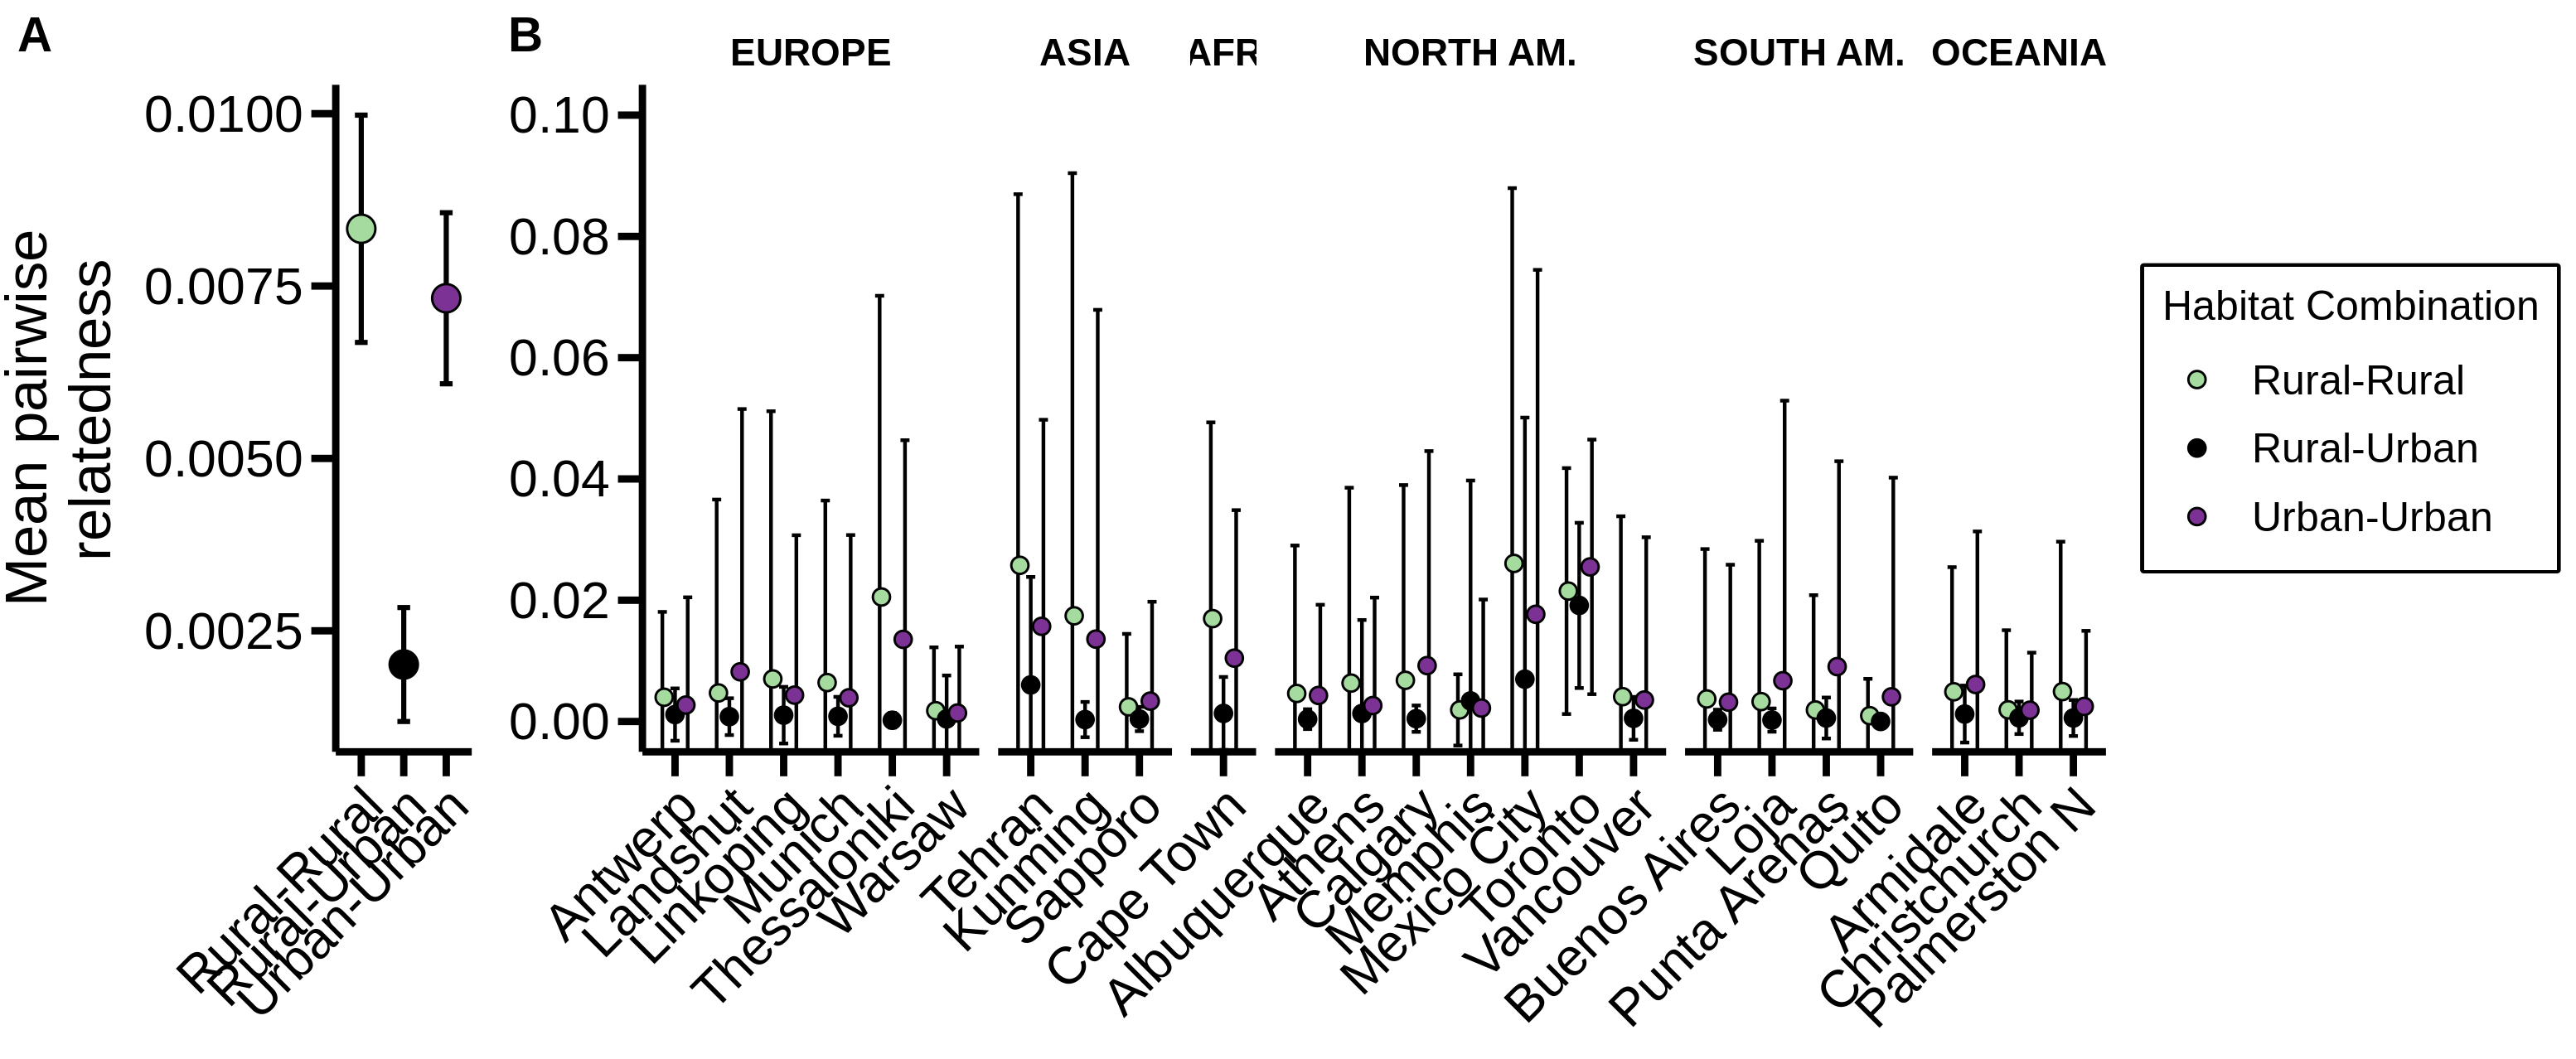

In [46]:
# Global rab
rab_by_habitat <- inbr_table %>% 
  group_by(habitat_combo) %>% 
  summarise(mean = mean(rab),
            sd = sd(rab),
            se = sd / sqrt(n())) %>% 
  mutate(habitat_combo = fct_recode(habitat_combo, 'Rural-Rural' = 'rr', 'Urban-Urban' = 'uu', 'Rural-Urban' = 'ru'),
         global = rep("",3)) %>% 
  ggplot(., aes(x = habitat_combo, y = mean, fill = habitat_combo)) +
  geom_errorbar(aes(ymax = mean + se, ymin = mean - se), width = 0.3, size = .7) +
  geom_point(size = 3.5, shape = 21) +
  facet_grid(~global,scales="free_x", space="free_x")+
  #coord_cartesian(ylim = c(0,0.1)) +
  scale_y_continuous(breaks=c(0,0.02,0.04,0.06,0.08,0.1))+
  #scale_y_continuous(breaks=c(0.024,0.026,0.028))+
  #ylim(0.022,0.03)+
  scale_fill_manual(values = rev(cols), labels = c('Rural-Rural', 'Urban-Urban','Rural-Urban')) +
  ylab('Mean pairwise\n relatedness')  +
  ng2 +
  theme(strip.placement ="outside", strip.background=element_rect(colour="white",fill="white"))+
  theme(legend.position = "none")

# rab per city per habitat
rab_by_city_by_habitat <- inbr_table %>% 
  mutate(habitat_combo = fct_recode(habitat_combo, 'Rural-Rural' = 'rr', 'Urban-Urban' = 'uu', 'Rural-Urban' = 'ru')) %>% 
  #mutate(habitat = fct_recode(city, 'Palmerston N' = 'Palmerston_North'))%>% 
  ggplot(., aes(x = factor(city, level = level_order), y = rab, fill = habitat_combo)) +
  geom_errorbar(aes(ymax = rab + rab_sd, ymin = rab - rab_sd), width = 0.5, size = 0.5, position=position_dodge(width = 0.7)) +
  geom_point(size = 2, shape = 21, position=position_dodge(width = 0.6)) +
  #scale_y_continuous(coord_cartesian(ylim = c(0,2)))+
  scale_fill_manual(values = rev(cols), labels = c('Rural-Rural', 'Rural-Urban', 'Urban-Urban'), name="Habitat Combination") +
  #scale_y_continuous(limits=c(0.018,0.04))+
  coord_cartesian(ylim = c(0,0.1)) +
  facet_grid(~continent_order,scales="free_x", space="free_x")+
  #facet_wrap(~continent_order,scales="free_x", space="free_x")+
  scale_y_continuous(breaks=c(0,0.02,0.04,0.06,0.08,0.1))+
  #                  
  #ylab('Pairwise nucleotide diversity') +
  ng2 +
  theme(strip.placement ="outside", 
        strip.background=element_rect(colour="white",fill="white"),
        strip.text.x=element_text(size=11))+
  theme(legend.position = "right",
        legend.direction="vertical",
        legend.box.background = element_rect(colour = "black",size=1),
        legend.text=element_text(size=12),
        legend.title=element_text(size=12),
        axis.title.y=element_blank())

rab_combined<-ggarrange(rab_by_habitat,rab_by_city_by_habitat, ncol=2,nrow=1,widths=c(0.4,1.7),align="h",labels=c("A","B"))

ggsave(rab_combined,
    path="/scratch/projects/trifolium/glue/demography/glue_demography/genomic-analyses/analyses/figures/",
    filename="rab_mean_plot.png", width = 10.36, height = 4.26, unit="in")

display_png(file="/scratch/projects/trifolium/glue/demography/glue_demography/genomic-analyses/analyses/figures/rab_mean_plot.png")


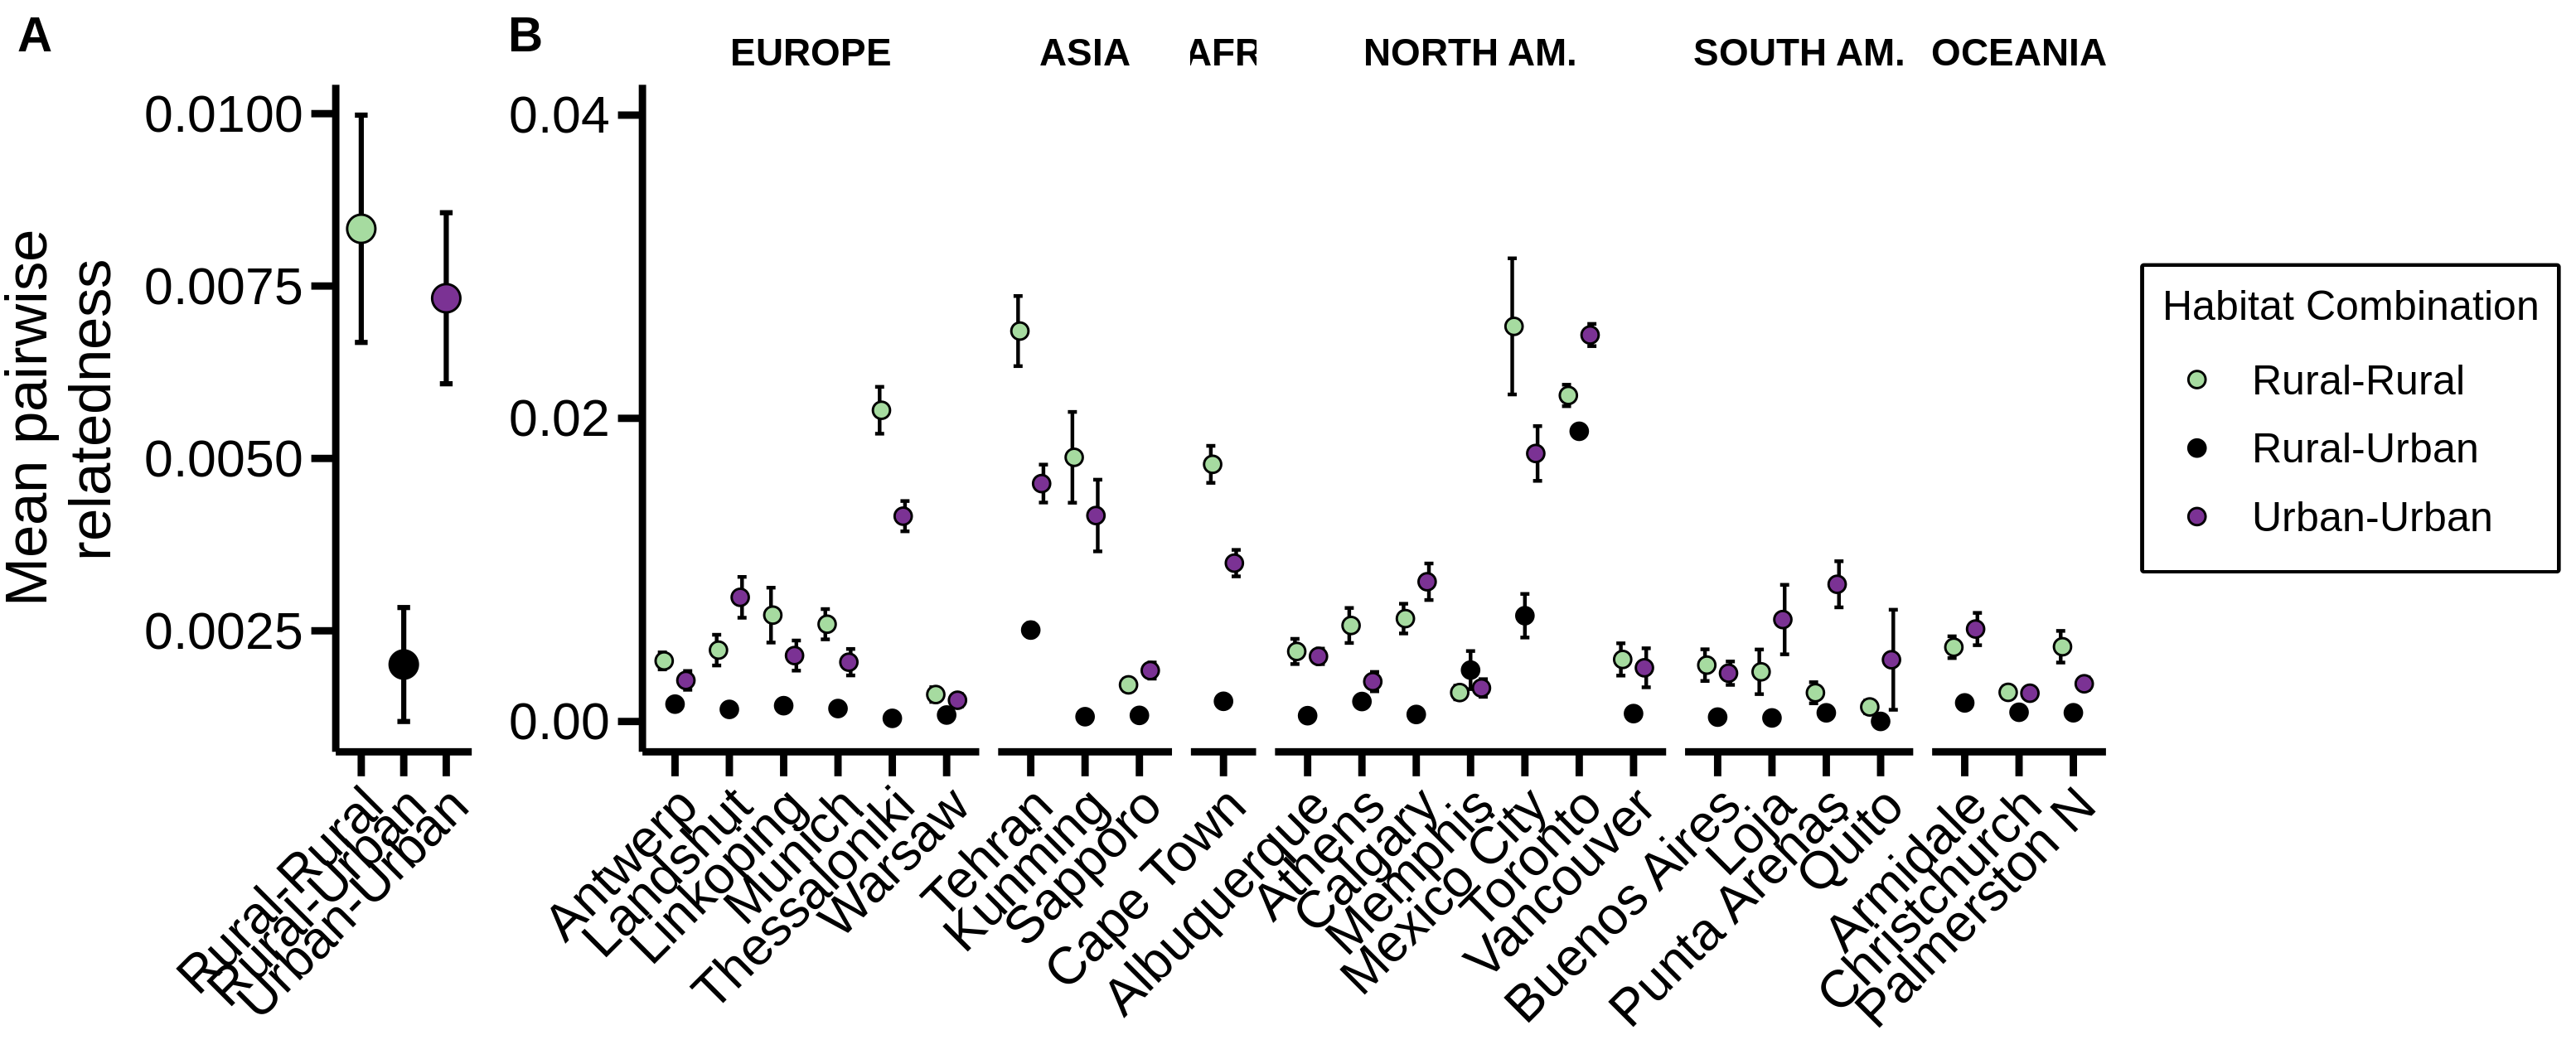

In [55]:
# Global rab
rab_by_habitat <- inbr_table %>% 
  group_by(habitat_combo) %>% 
  summarise(mean = mean(rab),
            sd = sd(rab),
            se = sd / sqrt(n())) %>% 
  mutate(habitat_combo = fct_recode(habitat_combo, 'Rural-Rural' = 'rr', 'Urban-Urban' = 'uu', 'Rural-Urban' = 'ru'),
         global = rep("",3)) %>% 
  ggplot(., aes(x = habitat_combo, y = mean, fill = habitat_combo)) +
  geom_errorbar(aes(ymax = mean + se, ymin = mean - se), width = 0.3, size = .7) +
  geom_point(size = 3.5, shape = 21) +
  facet_grid(~global,scales="free_x", space="free_x")+
  #coord_cartesian(ylim = c(0,0.1)) +
  #scale_y_continuous(breaks=c(0,0.02,0.04))+
  #scale_y_continuous(breaks=c(0.024,0.026,0.028))+
  #ylim(0.022,0.03)+
  scale_fill_manual(values = rev(cols), labels = c('Rural-Rural', 'Urban-Urban','Rural-Urban')) +
  ylab('Mean pairwise\n relatedness')  +
  ng2 +
  theme(strip.placement ="outside", strip.background=element_rect(colour="white",fill="white"))+
  theme(legend.position = "none")

# rab per city per habitat
rab_by_city_by_habitat <- inbr_table %>% 
  mutate(habitat_combo = fct_recode(habitat_combo, 'Rural-Rural' = 'rr', 'Urban-Urban' = 'uu', 'Rural-Urban' = 'ru')) %>% 
  #mutate(habitat = fct_recode(city, 'Palmerston N' = 'Palmerston_North'))%>% 
  ggplot(., aes(x = factor(city, level = level_order), y = rab, fill = habitat_combo)) +
  geom_errorbar(aes(ymax = rab + rab_se, ymin = rab - rab_se), width = 0.5, size = 0.5, position=position_dodge(width = 0.7)) +
  geom_point(size = 2, shape = 21, position=position_dodge(width = 0.6)) +
  #scale_y_continuous(coord_cartesian(ylim = c(0,2)))+
  scale_fill_manual(values = rev(cols), labels = c('Rural-Rural', 'Rural-Urban', 'Urban-Urban'), name="Habitat Combination") +
  #scale_y_continuous(limits=c(0.018,0.04))+
  coord_cartesian(ylim = c(0,0.04)) +
  facet_grid(~continent_order,scales="free_x", space="free_x")+
  #facet_wrap(~continent_order,scales="free_x", space="free_x")+
  scale_y_continuous(breaks=c(0,0.02,0.04))+
  #                  
  #ylab('Pairwise nucleotide diversity') +
  ng2 +
  theme(strip.placement ="outside", 
        strip.background=element_rect(colour="white",fill="white"),
        strip.text.x=element_text(size=11))+
  theme(legend.position = "right",
        legend.direction="vertical",
        legend.box.background = element_rect(colour = "black",size=1),
        legend.text=element_text(size=12),
        legend.title=element_text(size=12),
        axis.title.y=element_blank())

rab_combined<-ggarrange(rab_by_habitat,rab_by_city_by_habitat, ncol=2,nrow=1,widths=c(0.4,1.7),align="h",labels=c("A","B"))

ggsave(rab_combined,
    path="/scratch/projects/trifolium/glue/demography/glue_demography/genomic-analyses/analyses/figures/",
    filename="rab_mean_plot.png", width = 10.36, height = 4.26, unit="in")

display_png(file="/scratch/projects/trifolium/glue/demography/glue_demography/genomic-analyses/analyses/figures/rab_mean_plot.png")


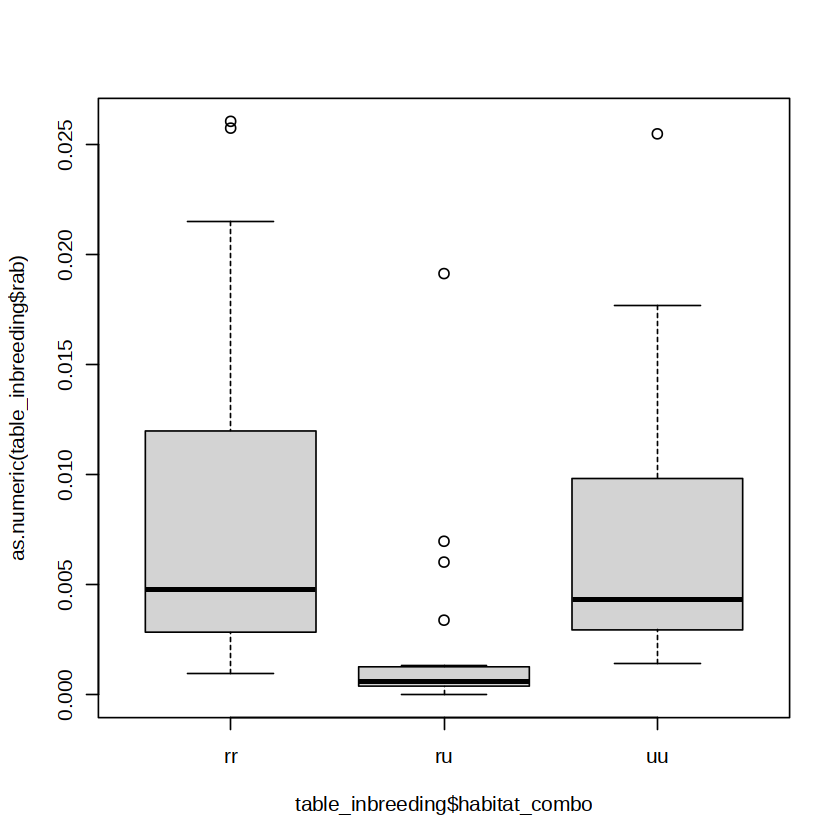

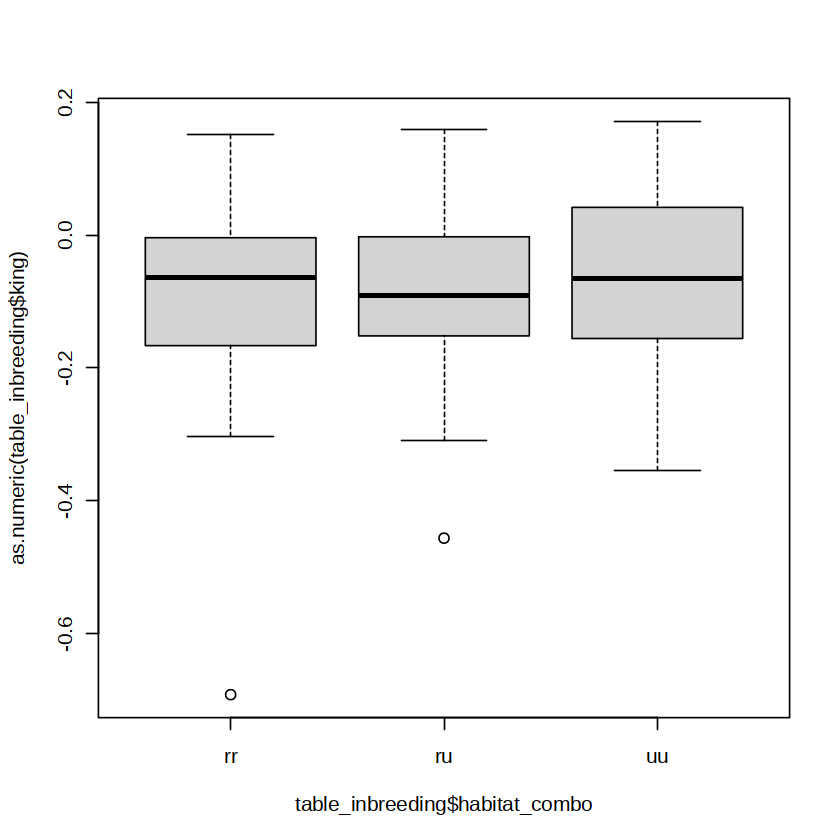

In [19]:
boxplot(as.numeric(table_inbreeding$rab)~table_inbreeding$habitat_combo	)
boxplot(as.numeric(table_inbreeding$king)~table_inbreeding$habitat_combo	)

In [22]:
rr_ru<-subset(table_inbreeding, table_inbreeding$habitat_combo=="rr" | table_inbreeding$habitat_combo=="ru")
rr_uu<-subset(table_inbreeding, table_inbreeding$habitat_combo=="rr" | table_inbreeding$habitat_combo=="uu")
ru_uu<-subset(table_inbreeding, table_inbreeding$habitat_combo=="ru" | table_inbreeding$habitat_combo=="uu")

rr_ru$rab1<-as.numeric(rr_ru$rab)
rr_uu$rab1<-as.numeric(rr_uu$rab)
ru_uu$rab1<-as.numeric(ru_uu$rab)

rr_ru$king1<-as.numeric(rr_ru$king)
rr_uu$king1<-as.numeric(rr_uu$king)
ru_uu$king1<-as.numeric(ru_uu$king)

In [20]:
wilcox.test(rr_ru$rab1~rr_ru$habitat_combo, data = rr_ru, paired = TRUE, alternative="greater")
wilcox.test(rr_uu$rab1~rr_uu$habitat_combo, data = rr_uu, paired = TRUE, alternative="two.sided")
wilcox.test(ru_uu$rab1~ru_uu$habitat_combo, data = ru_uu, paired = TRUE, alternative="less")



	Wilcoxon signed rank exact test

data:  rr_ru$rab1 by rr_ru$habitat_combo
V = 295, p-value = 5.96e-07
alternative hypothesis: true location shift is greater than 0



	Wilcoxon signed rank exact test

data:  rr_uu$rab1 by rr_uu$habitat_combo
V = 187, p-value = 0.3029
alternative hypothesis: true location shift is not equal to 0



	Wilcoxon signed rank exact test

data:  ru_uu$rab1 by ru_uu$habitat_combo
V = 2, p-value = 1.788e-07
alternative hypothesis: true location shift is less than 0


In [23]:
wilcox.test(rr_ru$king1~rr_ru$habitat_combo, data = rr_ru, paired = TRUE, alternative="two.sided")
wilcox.test(rr_uu$king1~rr_uu$habitat_combo, data = rr_uu, paired = TRUE, alternative="two.sided")
wilcox.test(ru_uu$king1~ru_uu$habitat_combo, data = ru_uu, paired = TRUE, alternative="two.sided")



	Wilcoxon signed rank exact test

data:  rr_ru$king1 by rr_ru$habitat_combo
V = 144, p-value = 0.8774
alternative hypothesis: true location shift is not equal to 0



	Wilcoxon signed rank exact test

data:  rr_uu$king1 by rr_uu$habitat_combo
V = 123, p-value = 0.4559
alternative hypothesis: true location shift is not equal to 0



	Wilcoxon signed rank exact test

data:  ru_uu$king1 by ru_uu$habitat_combo
V = 104, p-value = 0.1974
alternative hypothesis: true location shift is not equal to 0
